# NLP Engineer Internship Test

## Objective

- Make an intent classifier with the dataset provided in the repository in which the imput will be a phrase and the model must correctly classify it in one of the intentions defined in the dataset
- The main objective of the test is to assess the candidate's ability to solve problems and demonstrate his attempts, hypotheses, solutions clearly and the ability to analyze data, extract information, suggest conclusions, and support decision-making.

### Example interaction with the resulting model
Just a demonstrative example to understand the problem, the output can be formatted according to the candidate's preference so that it shows the intention and the confidence that the model returned
```
example 1:
input: como ocorre a transferência de processos para o SEI?
output: 
intent: processos_administrativos 
confidence: 96.7%

example 2:
input: quais são os documentos disponíveis?
output: 
intent: documentação
confidence: 83.2%
```

## Information about the datasets

The dataset is in the dataset.txt file in the repository, it is in the format:

```
intent:intent_name1
-sentence1
-sentence2
...
-sentenceN

intent:intent_name2
-sentence1
-sentence2
...
-sentenceN

...
```

## Requirements
- Put all the code, logic, hypotheses, etc. organized in the nlp_test.pynb jupyter notebook of the repository (i.e. specific actions you would take based on your analysis) and methodology.
- Fork this repository
- Make your fork private
- Give access to the user "lucasraggi89" in your private fork
- Make all changes in your fork
- Only the commits before the deadline will be considered

Tip: it is interesting to put your different approaches and attempts in the notebook to support decision making<br/>
Have fun!

___
# Starting my test here!

## Content

- [Introduction to the problem](#Introduction-to-the-problem)
- [The dataset](#The-dataset)
- [Preprocessing our data](#Preprocessing-our-data)
- [Feature Extraction: Transforming words in numbers](#Feature-Extraction:-Transforming-words-in-numbers)
- [Taking a look at the ML models (Model Selection)](#Taking-a-look-at-the-ML-models-(Model-Selection))
- [Conclusion and Decision](#Conclusion-and-Decision)
- [Interaction with the resulting model](#Interaction-with-the-resulting-model)

## Introduction to the problem

The given problem is a NLP problem, where we receive an user's interaction phrase, and the task is to process this content and classify in useful **intents** to make smartful automated decisions, generally used in chatbots.

## The dataset

The provided data is simple, consists in one *.txt* file with some inputs separeted by the intent class. As it is in no structured format (as *.json*, *.csv*, etc), I'm going to create a parser function which transforms this text data into python *dict*, to facility the data wrangling, manipulations and Pandas DataFrame creation. 

In [127]:
import pandas as pd

def txt_data_to_dict(filepath):
    # creating dict which
    data_dict = {
                'phrase': [],
                'intent': [],
                }
    try:
        with open(filepath, 'r') as txt_file:
            # processing the lines
            intent_class = None
            phrase = None
            for line in txt_file:
                if 'intent' in line:
                    # get intent class and remove '\n' charactere
                    intent_class = line.split(':')[1].replace('\n', '')
                    continue
                if '-' in line:
                    # get string after '-' and remove blank spaces from the end and beginning
                    phrase = line[1:].strip()
                    # adding this 'row' to the dict
                    data_dict['phrase'].append(phrase)
                    data_dict['intent'].append(intent_class)
            
            return data_dict
    except FileNotFoundError:
        print('The file was not found, make sure the filepath is correct.')
            
            
path = 'data.txt'
data = txt_data_to_dict(path)
# Creating pandas DataFrame from dict:
df = pd.DataFrame.from_dict(data)

So, here we have a pandas DataFrame with two columns:
1. The user input **phrase**
2. The class which represents the **intent**

In [128]:
df.head()

,phrase,intent
0,apg,competencias
1,APG,competencias
2,Assessoria de Planejamento e Gestão,competencias
3,onde a diretoria financeira atua,competencias
4,qual a função principal da diretoria geral ?,competencias


### Dataset distribution

It's also important take a look at the class distribution in our dataset, because it must impact directly at the result model. So:

Text(0, 0.5, 'Frequency')

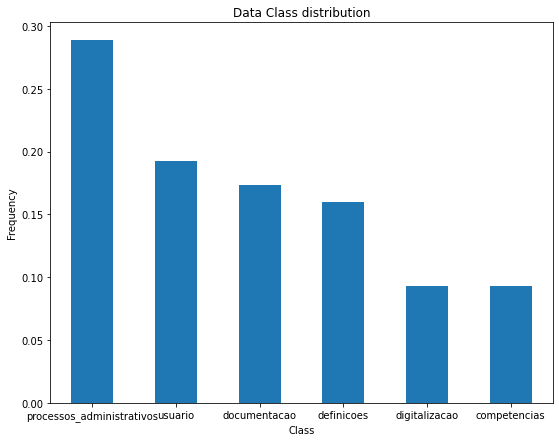

In [129]:
import matplotlib.pyplot as plt

count_classes = pd.value_counts(df['intent'], sort = True) / len(df['intent'])

# Creating a plot with bar kind:
count_classes.plot(kind = 'bar', rot=0, figsize=(9, 7))

# Setting plotting title and axi's legends:
plt.title("Data Class distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")

We can consider that the dataset is balanced, it's not critical enough to use imbalanced data techniques.

## Preprocessing our data

Now that we have our dataset ready, we start the most important phase in a Data Science pipeline and must start to apply some preprocessing NLP techniques to get a better representation of the data and input to the ML model. As the saying goes "Garbage in, garbage out!".

### Converted Accented Characters

Words with accent marks like “não” and “usuário” can be converted and standardized to “nao” and “usuario”, else our NLP model will treat “não” and “nao” as different words even though they are referring to same thing. To do this, we use the module unidecode.

In [130]:
# If unidecode library isn't installed, uncomment the line bellow to install
# !pip install unidecode

from unidecode import unidecode

def remove_accented_chars(dict_data, column_name):
    """remove accented characters from text, e.g. usuário"""
    # Create lambda function to decode
    remove_accent = lambda x: unidecode(x)
    # Apply lambda with map() in list
    no_accented_phrases = list(map(remove_accent, dict_data[column_name]))
    # Get new values without accent
    dict_data[column_name] = no_accented_phrases
    
    return dict_data

data = remove_accented_chars(data, 'phrase')
# Creating pandas DataFrame from dict:
df = pd.DataFrame.from_dict(data)

### Lowercasing

Lowercasing ALL your text data is one of the simplest and most effective form of text preprocessing. It is applicable to most text mining and NLP problems and can help in cases where your dataset is not very large and significantly helps with consistency of expected output decreasing the variation of words to be understood by the model.

In [131]:
def lowercasing_data(dict_data, column_name):
    """remove accented characters from text, e.g. usuário"""
    # Create lambda function to lowercase
    lowercasing = lambda x: x.lower()
    # Apply lambda with map() in list
    lowercased_phrases = list(map(lowercasing, dict_data[column_name]))
    # Get new lowercased values
    dict_data[column_name] = lowercased_phrases
    
    return dict_data

data = lowercasing_data(data, 'phrase')
# Creating pandas DataFrame from dict:
df = pd.DataFrame.from_dict(data)

### Extra Blank Space Removal

In [132]:
def remove_extra_spaces(data, column_name):
    # Create lambda function to remove extra blank spaces
    remove_spaces = lambda x: " ".join(x.split())
    # Apply lambda with map() in list
    cleaned_phrases = list(map(remove_spaces, data[column_name]))
    # Get new lowercased values
    data[column_name] = cleaned_phrases
    
    return data
        
data = remove_extra_spaces(data, 'phrase')
# Creating pandas DataFrame from dict:
df = pd.DataFrame.from_dict(data)

### Stopwords Removal

Stop words are a set of commonly used words in a language. Examples of stop words in Portuguese are “a”, “o”, “é”, “da” and etc. The intuition behind using stop words is that, by removing low information words from text, we can focus on the **important** words instead.

In [133]:
# If spacy library isn't installed, uncomment the line bellow to install
# !pip install spacy

from spacy.lang.pt import Portuguese
from spacy.lang.pt.stop_words import STOP_WORDS

def remove_stop_words(data):
    # Load Portuguese tokenizer, tagger, parser, NER and word vectors
    nlp = Portuguese()
    size = len(data['phrase'])
    # New dict to put preprocessed data
    cleaned_dict = {
                'phrase': [],
                'intent': [],
                }
    
    for i in range(size):
        my_doc = nlp(data['phrase'][i])
        intent_class = data['intent'][i]
        
        # Create list of word tokens
        token_list = []
        
        for token in my_doc:
            token_list.append(token.text)
        
        # Create list of word tokens after removing stopwords
        filtered_sentence = ''

        for word in token_list:
            lexeme = nlp.vocab[word]
            if lexeme.is_stop == False:
                filtered_sentence += word + ' '
                
        cleaned_dict['phrase'].append(filtered_sentence[:-1])
        cleaned_dict['intent'].append(intent_class)
        filtered_sentence = ''
    
    return cleaned_dict

data = remove_stop_words(data)
# Creating pandas DataFrame from dict:
df = pd.DataFrame.from_dict(data)

### Text Normalization

Text Normalization is a process of transforming a word into a single canonical form. This can be done by two processes, stemming and lemmatization. I'm going to choose **lemmatization** because I'm using SpaCy and has no module for stemming. To perform lemmatization, check out the below code:

In [134]:
from spacy.lang.pt import Portuguese

def normalize_data(data):
    nlp = Portuguese()
    size = len(data['phrase'])
    
    normalized_dict = {
                'phrase': [],
                'intent': [],
                }
    for i in range(size):
        doc = nlp(data['phrase'][i])
        intent_class = data['intent'][i]
        lemma_word = ''
        for token in doc:
            lemma_word += token.lemma_ + ' '
        normalized_dict['phrase'].append(lemma_word[:-1])
        normalized_dict['intent'].append(intent_class)
        lemma_word = ''
        
    return normalized_dict

data = normalize_data(data)
# Creating pandas DataFrame from dict:
df = pd.DataFrame.from_dict(data)

## More treatments that I won't use

Exist more strategies to preprocess the data to the NLP problems, but I judge them not necessary for our dataset. I going to list a few bellow:

- Convert number words to numeric form -> Convert "três" to "3"
- Remove numbers -> Identify number like "3" and remove them
- Remove pontuation -> Remove from phrase characteres like: '!', '?', ','
- Text Enrichment / Augmentation

## Feature Extraction: Transforming words in numbers

In order to run machine learning algorithms (which are mathematical/statistical models) we need to convert the text into numbers. For this, we have some famous approches like:

- Count Vector
- TF-IDF Count
- Word2Vec
- Doc2Vec

I'm going to use some of them to transform our dataset and pass to the next step of pipeline.

In [135]:
# !pip install sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

count_vectorizer = CountVectorizer()

tfid_vectorizer = TfidfVectorizer()

vectorizer_methods = [count_vectorizer, tfid_vectorizer]

## Taking a look at the ML models (Model Selection)

### Splitting the dataset

In [136]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split

X = df['phrase']
y = df['intent']
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

### Approach at model selection

I'm going to choose models from different categories, e.g. linear models, ensemble methods, SVMs..

And evaluate each model tuning the hyper-parameters with a Grid Search and Cross Validation.

For this, I'll build a general function which receives the classifier, parameters for hyper-tuning, vectorizer methods and the metrics to evaluate.

In [137]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
       
def search_best_model(classifier, scores, tuned_parameters, vectorizer_methods):

    for score in scores:
        for vect in vectorizer_methods:
            print("# Tuning hyper-parameters with " + vect.__class__.__name__ + " for %s" % score)
            print()
            
            # Intance the grid search and choose Cross Validation folders 
            clf = GridSearchCV(
                classifier, tuned_parameters, cv=10, scoring='%s' % score
                )

            X_train_vectorized = vect.fit_transform(X_train)
            clf.fit(X_train_vectorized, y_train)

            print("Best parameters set found:")
            print()
            print(clf.best_params_)
            print()
            print("Best score result: " + str(clf.best_score_))
            print()
            print("Scores on development set:")
            print()
            
            means = clf.cv_results_['mean_test_score']
            stds = clf.cv_results_['std_test_score']
            for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                print("%0.3f (+/-%0.03f) for %r"
                      % (mean, std * 2, params))
            print()
            X_test_vectorized = vect.transform(X_test)
            y_true, y_pred = y_test, clf.predict(X_test_vectorized)

### Linear Models: Stochastic Gradient Descent (SGD)

In [138]:
from sklearn.linear_model import SGDClassifier

# Set the parameters for the grid search
tuned_parameters = [{'loss': ['hinge', 'squared_hinge', 'modified_huber'], 'penalty': ['l1', 'l2']},
                    {'loss': ['hinge', 'squared_hinge', 'modified_huber'], 'max_iter': [1000, 500, 700]}]

# Define the metrics to evaluate the model
scores = ['accuracy']

search_best_model(SGDClassifier(), scores, tuned_parameters, vectorizer_methods)

# Tuning hyper-parameters with CountVectorizer for accuracy

Best parameters set found:

{'loss': 'hinge', 'max_iter': 1000}

Best score result: 0.8413105413105413

Scores on development set:

0.830 (+/-0.087) for {'loss': 'hinge', 'penalty': 'l1'}
0.804 (+/-0.125) for {'loss': 'hinge', 'penalty': 'l2'}
0.811 (+/-0.118) for {'loss': 'squared_hinge', 'penalty': 'l1'}
0.796 (+/-0.120) for {'loss': 'squared_hinge', 'penalty': 'l2'}
0.834 (+/-0.113) for {'loss': 'modified_huber', 'penalty': 'l1'}
0.830 (+/-0.102) for {'loss': 'modified_huber', 'penalty': 'l2'}
0.841 (+/-0.125) for {'loss': 'hinge', 'max_iter': 1000}
0.822 (+/-0.097) for {'loss': 'hinge', 'max_iter': 500}
0.826 (+/-0.131) for {'loss': 'hinge', 'max_iter': 700}
0.808 (+/-0.140) for {'loss': 'squared_hinge', 'max_iter': 1000}
0.815 (+/-0.162) for {'loss': 'squared_hinge', 'max_iter': 500}
0.796 (+/-0.122) for {'loss': 'squared_hinge', 'max_iter': 700}
0.799 (+/-0.147) for {'loss': 'modified_huber', 'max_iter': 1000}
0.834 (+/

### Linear Models: Logistic Regression

In [139]:
from sklearn.linear_model import LogisticRegression

# Set the parameters for the grid search
tuned_parameters = [{'penalty': ['l1', 'l2', 'elasticnet'], 'C': [1, 0.5, 1.5],
                    'solver': ['liblinear', 'lbfgs', 'newton-cg']}]

# Define the metrics to evaluate the model
scores = ['accuracy']

search_best_model(LogisticRegression(), scores, tuned_parameters, vectorizer_methods)

# Tuning hyper-parameters with CountVectorizer for accuracy

Best parameters set found:

{'C': 1.5, 'penalty': 'l2', 'solver': 'liblinear'}

Best score result: 0.8756410256410257

Scores on development set:

0.777 (+/-0.144) for {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
nan (+/-nan) for {'C': 1, 'penalty': 'l1', 'solver': 'lbfgs'}
nan (+/-nan) for {'C': 1, 'penalty': 'l1', 'solver': 'newton-cg'}
0.857 (+/-0.111) for {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
0.864 (+/-0.114) for {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.864 (+/-0.114) for {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
nan (+/-nan) for {'C': 1, 'penalty': 'elasticnet', 'solver': 'liblinear'}
nan (+/-nan) for {'C': 1, 'penalty': 'elasticnet', 'solver': 'lbfgs'}
nan (+/-nan) for {'C': 1, 'penalty': 'elasticnet', 'solver': 'newton-cg'}
0.706 (+/-0.128) for {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}
nan (+/-nan) for {'C': 0.5, 'penalty': 'l1', 'solver': 'lbfgs'}
nan (+/-nan) for {'C': 0.5, 'penal

### Support Vector Machine (SVM):

In [140]:
from sklearn.svm import SVC

# Set the parameters for the grid search
tuned_parameters = [{'C': [0.5, 0.7, 1, 1.5], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}]

# Define the metrics to evaluate the model
scores = ['accuracy']

search_best_model(SVC(), scores, tuned_parameters, vectorizer_methods)

# Tuning hyper-parameters with CountVectorizer for accuracy

Best parameters set found:

{'C': 0.7, 'kernel': 'linear'}

Best score result: 0.8717948717948717

Scores on development set:

0.827 (+/-0.156) for {'C': 0.5, 'kernel': 'linear'}
0.630 (+/-0.188) for {'C': 0.5, 'kernel': 'poly'}
0.676 (+/-0.155) for {'C': 0.5, 'kernel': 'rbf'}
0.759 (+/-0.129) for {'C': 0.5, 'kernel': 'sigmoid'}
0.872 (+/-0.141) for {'C': 0.7, 'kernel': 'linear'}
0.657 (+/-0.168) for {'C': 0.7, 'kernel': 'poly'}
0.755 (+/-0.176) for {'C': 0.7, 'kernel': 'rbf'}
0.830 (+/-0.134) for {'C': 0.7, 'kernel': 'sigmoid'}
0.864 (+/-0.141) for {'C': 1, 'kernel': 'linear'}
0.687 (+/-0.150) for {'C': 1, 'kernel': 'poly'}
0.819 (+/-0.132) for {'C': 1, 'kernel': 'rbf'}
0.838 (+/-0.138) for {'C': 1, 'kernel': 'sigmoid'}
0.841 (+/-0.127) for {'C': 1.5, 'kernel': 'linear'}
0.683 (+/-0.156) for {'C': 1.5, 'kernel': 'poly'}
0.849 (+/-0.108) for {'C': 1.5, 'kernel': 'rbf'}
0.861 (+/-0.156) for {'C': 1.5, 'kernel': 'sigmoid'}

# T

### Ensemble Methods - Random Forest:

In [141]:
from sklearn.ensemble import RandomForestClassifier

# Set the parameters for the grid search
tuned_parameters = [{'n_estimators': [50, 70, 100, 150, 300],
                     'max_depth': [4, 7, 10]}]

# Define the metrics to evaluate the model
scores = ['accuracy']

search_best_model(RandomForestClassifier(), scores, tuned_parameters, vectorizer_methods)

# Tuning hyper-parameters with CountVectorizer for accuracy

Best parameters set found:

{'max_depth': 10, 'n_estimators': 300}

Best score result: 0.7659544159544159

Scores on development set:

0.566 (+/-0.116) for {'max_depth': 4, 'n_estimators': 50}
0.521 (+/-0.151) for {'max_depth': 4, 'n_estimators': 70}
0.562 (+/-0.223) for {'max_depth': 4, 'n_estimators': 100}
0.532 (+/-0.134) for {'max_depth': 4, 'n_estimators': 150}
0.532 (+/-0.113) for {'max_depth': 4, 'n_estimators': 300}
0.694 (+/-0.152) for {'max_depth': 7, 'n_estimators': 50}
0.710 (+/-0.192) for {'max_depth': 7, 'n_estimators': 70}
0.709 (+/-0.188) for {'max_depth': 7, 'n_estimators': 100}
0.683 (+/-0.211) for {'max_depth': 7, 'n_estimators': 150}
0.709 (+/-0.178) for {'max_depth': 7, 'n_estimators': 300}
0.758 (+/-0.134) for {'max_depth': 10, 'n_estimators': 50}
0.758 (+/-0.180) for {'max_depth': 10, 'n_estimators': 70}
0.755 (+/-0.179) for {'max_depth': 10, 'n_estimators': 100}
0.762 (+/-0.153) for {'max_depth': 10, '

I realized that using ensemble models the efficiency goes down and time processing is higher. It's really nothing appropriated for this job.

### Naive Bayes - Bernoulli:

In [142]:
from sklearn.naive_bayes import BernoulliNB

# Set the parameters for the grid search
tuned_parameters = [{'alpha': [0.3, 0.5, 1.0],
                     'fit_prior': [True, False]}]

# Define the metrics to evaluate the model
scores = ['accuracy']

search_best_model(BernoulliNB(), scores, tuned_parameters, vectorizer_methods)

# Tuning hyper-parameters with CountVectorizer for accuracy

Best parameters set found:

{'alpha': 0.3, 'fit_prior': True}

Best score result: 0.8679487179487181

Scores on development set:

0.868 (+/-0.118) for {'alpha': 0.3, 'fit_prior': True}
0.864 (+/-0.112) for {'alpha': 0.3, 'fit_prior': False}
0.841 (+/-0.102) for {'alpha': 0.5, 'fit_prior': True}
0.853 (+/-0.132) for {'alpha': 0.5, 'fit_prior': False}
0.702 (+/-0.137) for {'alpha': 1.0, 'fit_prior': True}
0.759 (+/-0.119) for {'alpha': 1.0, 'fit_prior': False}

# Tuning hyper-parameters with TfidfVectorizer for accuracy

Best parameters set found:

{'alpha': 0.3, 'fit_prior': True}

Best score result: 0.8679487179487181

Scores on development set:

0.868 (+/-0.118) for {'alpha': 0.3, 'fit_prior': True}
0.864 (+/-0.112) for {'alpha': 0.3, 'fit_prior': False}
0.841 (+/-0.102) for {'alpha': 0.5, 'fit_prior': True}
0.853 (+/-0.132) for {'alpha': 0.5, 'fit_prior': False}
0.702 (+/-0.137) for {'alpha': 1.0, 'fit_prior': True}
0.759 (

## Conclusion and Decision

Analyzing our model evaluation pipeline we arrive at the best result for accuracy:

- **Best Vectorizer Technique:** Tfidf Vectorizer
- **Best Model:** Support Vector Classification (SVC)
- **Best parameters set found:** {'C': 1, 'kernel': 'linear'}

**Best score result: 0.8831908831908832**

## Interaction with the resulting model

#### Retraining the model with full dataset to do the interaction

In [144]:
from sklearn.utils import shuffle

# best_params = {'loss': 'hinge', 'max_iter': 1000}

clf = SVC(C=1, kernel='linear', probability=True)
# Shuffling all dataframe to train
df_train = shuffle(df)

X = df_train['phrase']
y = df_train['intent']

clf.fit(tfid_vectorizer.fit_transform(X), y)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

### Interacting:

In [145]:
# TYPE YOUR INPUT PHRASE HERE:
INPUT_PHRASE = 'como ocorre a transferência de processos para o SEI?'


# Modeling phrase to model predict:
input_dict = {'phrase': [INPUT_PHRASE]}
df_input = pd.DataFrame.from_dict(input_dict)


print("Classes to be predicted:")
print(clf.classes_, end='\n\n')
print("Prediction Confidence:", end='\n')
print(clf.predict_proba(tfid_vectorizer.transform(df_input['phrase']))[0], end='\n\n')
print("Intent Prediction:")
print(clf.predict(tfid_vectorizer.transform(df_input['phrase']))[0])

Classes to be predicted:
['competencias' 'definicoes' 'digitalizacao' 'documentacao'
 'processos_administrativos' 'usuario']

Prediction Confidence:
[0.01228124 0.01699306 0.01554672 0.01881749 0.89581218 0.04054931]

Intent Prediction:
processos_administrativos
